En este proyecto se trabajará con un conjunto de datos proporcionado por la plataforma Kaggle, específicamente de la competencia Spaceship Titanic. El objetivo principal es aplicar diferentes técnicas de clasificación para predecir si los pasajeros de una nave espacial fueron transportados a otra dimensión tras un accidente.

A lo largo del proyecto se explorarán los datos disponibles, se identificarán las variables más relevantes y se implementarán distintos modelos de clasificación: regresión logística multinomial, análisis discriminante lineal (LDA), árboles de decisión, y técnicas de ensamble como bagging, random forest o boosting. Cada modelo será evaluado utilizando validación cruzada y comparado en función de su precisión.

Finalmente, se seleccionará el mejor modelo para generar predicciones sobre los datos de prueba, las cuales serán cargadas en la plataforma de Kaggle para obtener una puntuación oficial. Este proceso permitirá evaluar la capacidad del modelo para resolver el problema de clasificación de manera efectiva.

Primero, comenzaré importando los datos de entrenamiento. A continuación, revisaré qué tipo de variables contiene la base de datos, identificando si se trata de variables cualitativas y/o cuantitativas. También comprobaré si existen valores faltantes (huecos) y analizaré la cantidad de variables disponibles, con el objetivo de determinar si es necesario realizar una limpieza o preprocesamiento de los datos.

In [2]:
# Primero importare todas las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier  as RFC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.tree import plot_tree
import warnings
warnings.filterwarnings('ignore')


data_train = pd.read_csv('train.csv')
data_train.head()

# Revisare los huecos
data_train.info()
print('\n')
print('Número de valores nulos: ')
print(data_train.isnull().sum())

print('\n')

# Tipo de variables (categóricas y numéricas)
print('Variables categóricas:')
print(data_train.select_dtypes(include='object').columns.tolist())

print('\nVariables numéricas:')
print(data_train.select_dtypes(include=['int64', 'float64']).columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Número de valores nulos: 
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age           

Al analizar el conjunto de datos proporcionado, se observa que contiene 8693 registros y 14 columnas. La variable objetivo que se busca predecir es Transported, la cual indica si un pasajero fue o no transportado a otra dimensión. Dado que esta variable solo presenta dos posibles valores (True o False), el problema se clasifica como una tarea de clasificación binaria.

Durante la exploración inicial, se detectaron valores faltantes en varias columnas, especialmente en CryoSleep, Cabin, VIP, Age, entre otras. Por esta razón, se procederá a realizar una limpieza del conjunto de datos, imputando los valores nulos mediante la moda de cada columna, con el objetivo de evitar inconsistencias durante el entrenamiento de los modelos.

Después, como los algoritmos de aprendizaje automático no pueden trabajar directamente con datos categóricos en formato texto, se codificarán las variables categóricas utilizando un codificador ordinal. Además, se aplicará un proceso de escalado a todas las variables numéricas, para que todas estén en la misma escala y se logre un mejor rendimiento en los modelos. Por último, el conjunto de datos se dividirá en dos subconjuntos: un 80% para entrenamiento y un 20% para prueba, lo que permitirá evaluar el rendimiento de los modelos de forma más objetiva.


In [4]:
# Se importan las librerias necesarias
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import statsmodels.api as sm
import pandas as pd

# Se Elimina la columna objetivo
X = data_train.drop('Transported', axis=1)
y = data_train['Transported'].astype(int)  # se convierte a int

# Eliminar huecos mediante moda
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Se codifican las variables categóricas
obj_cols = X_imputed.select_dtypes(include='object').columns
encoder = OrdinalEncoder()
X_imputed[obj_cols] = encoder.fit_transform(X_imputed[obj_cols])

# Comprobar que no queden valores nulos
print("¿Valores nulos")
print(X_imputed.isnull().sum().sum() == 0)  # Devuelve True si no hay nulos

¿Valores nulos
True


Una vez confirmada la limpieza y preparación de nuestra base de datos, se procederá a generar un modelo de regresión logística multinomial. Posteriormente, se evaluará la calidad del modelo mediante técnicas de validación cruzada, con el objetivo de obtener una estimación más robusta de su rendimiento.

Scores de validación cruzada: [0.77282531 0.7922358  0.78936017 0.78864127 0.80071942]
Media: 0.7887563938784271
Precisión final en conjunto de prueba: 0.772857964347326

Matriz de confusión:
[[623 238]
 [157 721]]


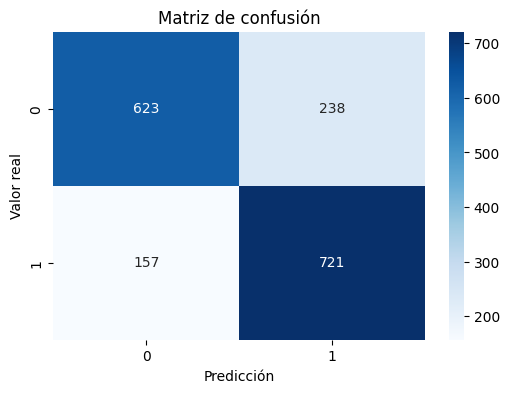


Informe de clasificación:
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       861
           1       0.75      0.82      0.78       878

    accuracy                           0.77      1739
   macro avg       0.78      0.77      0.77      1739
weighted avg       0.78      0.77      0.77      1739



In [40]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modelo
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Validación cruzada en el conjunto de entrenamiento
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Scores de validación cruzada:", scores)
print("Media:", np.mean(scores))

# Entrenamiento y evaluación
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión final en conjunto de prueba:", accuracy)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de confusión:")
print(cm)

# Visualización con seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()

# Informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred))



Tras aplicar el modelo de regresión logística, se obtuvo una precisión del 78%, lo que indica que el modelo acierta aproximadamente 8 de cada 10 predicciones. A continuación, se procederá a generar un modelo basado en Análisis Discriminante Lineal (LDA). Al igual que en el caso anterior, se evaluará la calidad del modelo mediante validación cruzada y se compararán los resultados obtenidos con los de la regresión logística para analizar su rendimiento.



Scores de validación cruzada (LDA): [0.77426312 0.79295471 0.78289001 0.78936017 0.79856115]
Media de precisión: 0.7876058319412047
Desviación estándar: 0.008390163001425954

Precisión en el conjunto de prueba: 0.7676825761932144

Matriz de confusión:
[[623 238]
 [166 712]]


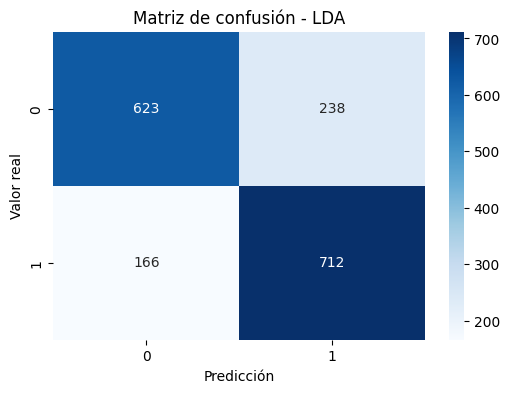


Informe de clasificación:
              precision    recall  f1-score   support

           0       0.79      0.72      0.76       861
           1       0.75      0.81      0.78       878

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739



In [42]:


# Modelo de LDA
lda_model = LinearDiscriminantAnalysis()

# Validación cruzada
lda_scores = cross_val_score(lda_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Scores de validación cruzada (LDA):", lda_scores)
print("Media de precisión:", np.mean(lda_scores))
print("Desviación estándar:", np.std(lda_scores))

# Entrenar el modelo completo con los datos de entrenamiento
lda_model.fit(X_train_scaled, y_train)

# Predecir en el conjunto de prueba
y_pred_lda = lda_model.predict(X_test_scaled)

# Calcular precisión
accuracy_lda = accuracy_score(y_test, y_pred_lda)
print("\nPrecisión en el conjunto de prueba:", accuracy_lda)

# Matriz de confusión
cm_lda = confusion_matrix(y_test, y_pred_lda)
print("\nMatriz de confusión:")
print(cm_lda)

# Visualizar matriz
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lda, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de confusión - LDA")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()

# Informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred_lda))

Al comparar la precisión (accuracy) de ambos modelos, se observa que sus resultados son muy similares. Mientras que la regresión logística alcanza una precisión del 78.87%, el modelo de Análisis Discriminante Lineal (LDA) obtiene un 78.76%. Esta mínima diferencia sugiere que ambos modelos presentan un rendimiento prácticamente equivalente en este conjunto de datos. Sin embargo, dado el ligero margen a favor de la regresión logística, este modelo puede considerarse como la opción más adecuada en este caso.

A continuación, se construirá un modelo basado en árboles de decisión. Como en los pasos anteriores, se evaluará su rendimiento mediante validación cruzada y se compararán los resultados obtenidos con los modelos previamente analizados.

Precisión del árbol con poda (ccp_alpha=0.005): 0.7660

Matriz de confusión:
[[575 286]
 [121 757]]


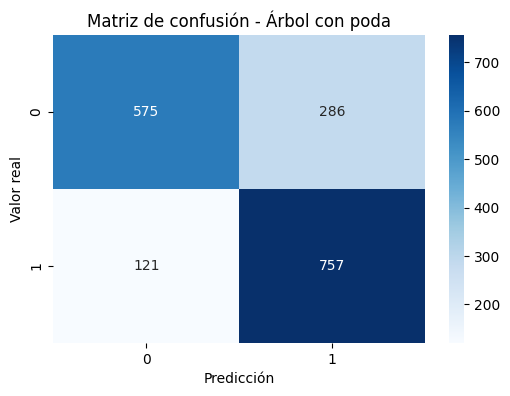


Informe de clasificación:
              precision    recall  f1-score   support

           0       0.83      0.67      0.74       861
           1       0.73      0.86      0.79       878

    accuracy                           0.77      1739
   macro avg       0.78      0.77      0.76      1739
weighted avg       0.78      0.77      0.76      1739



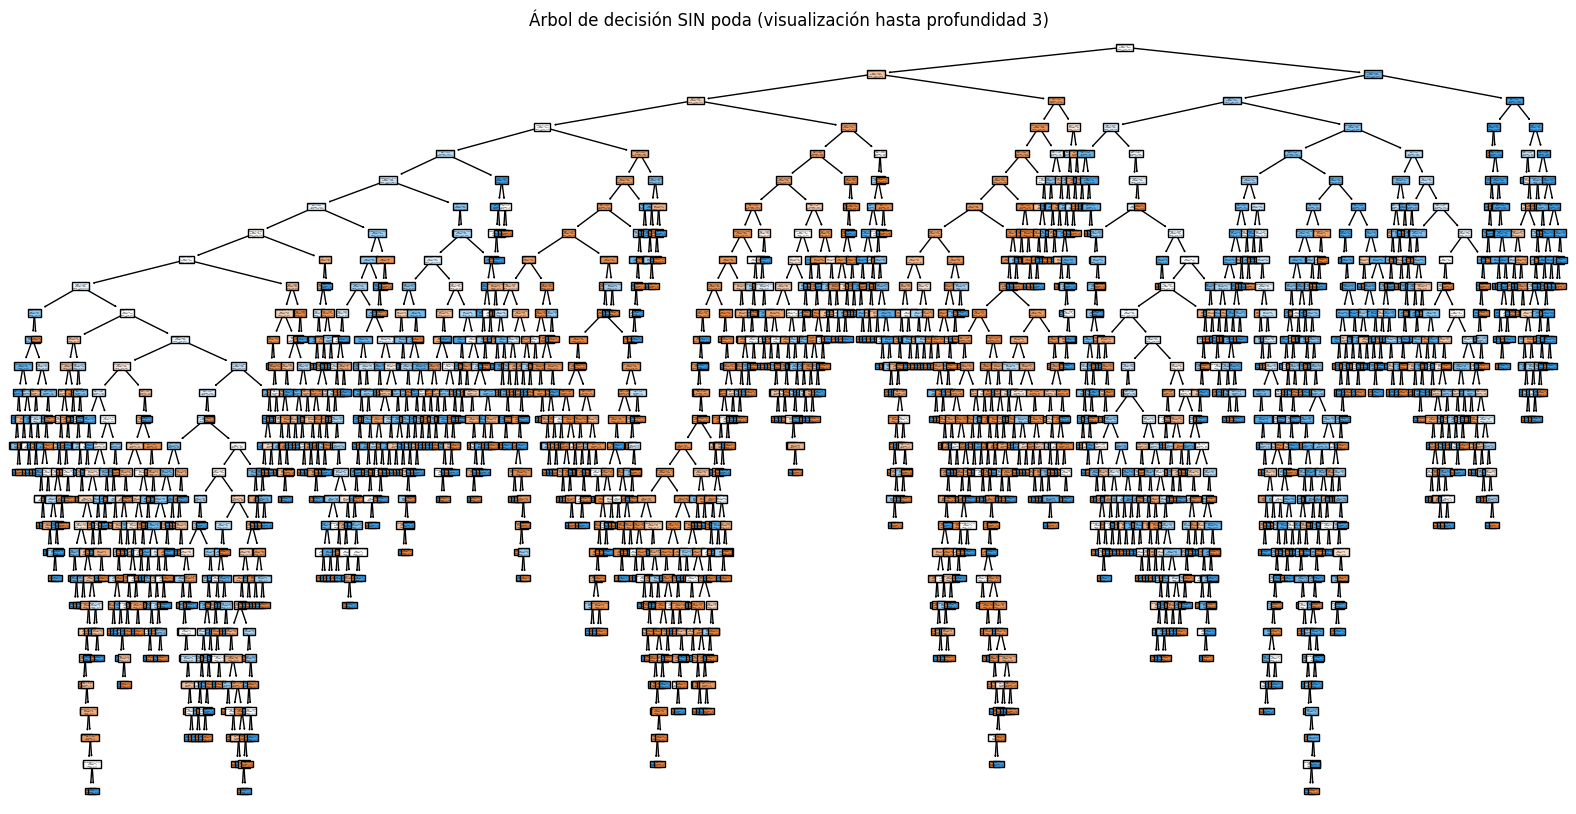

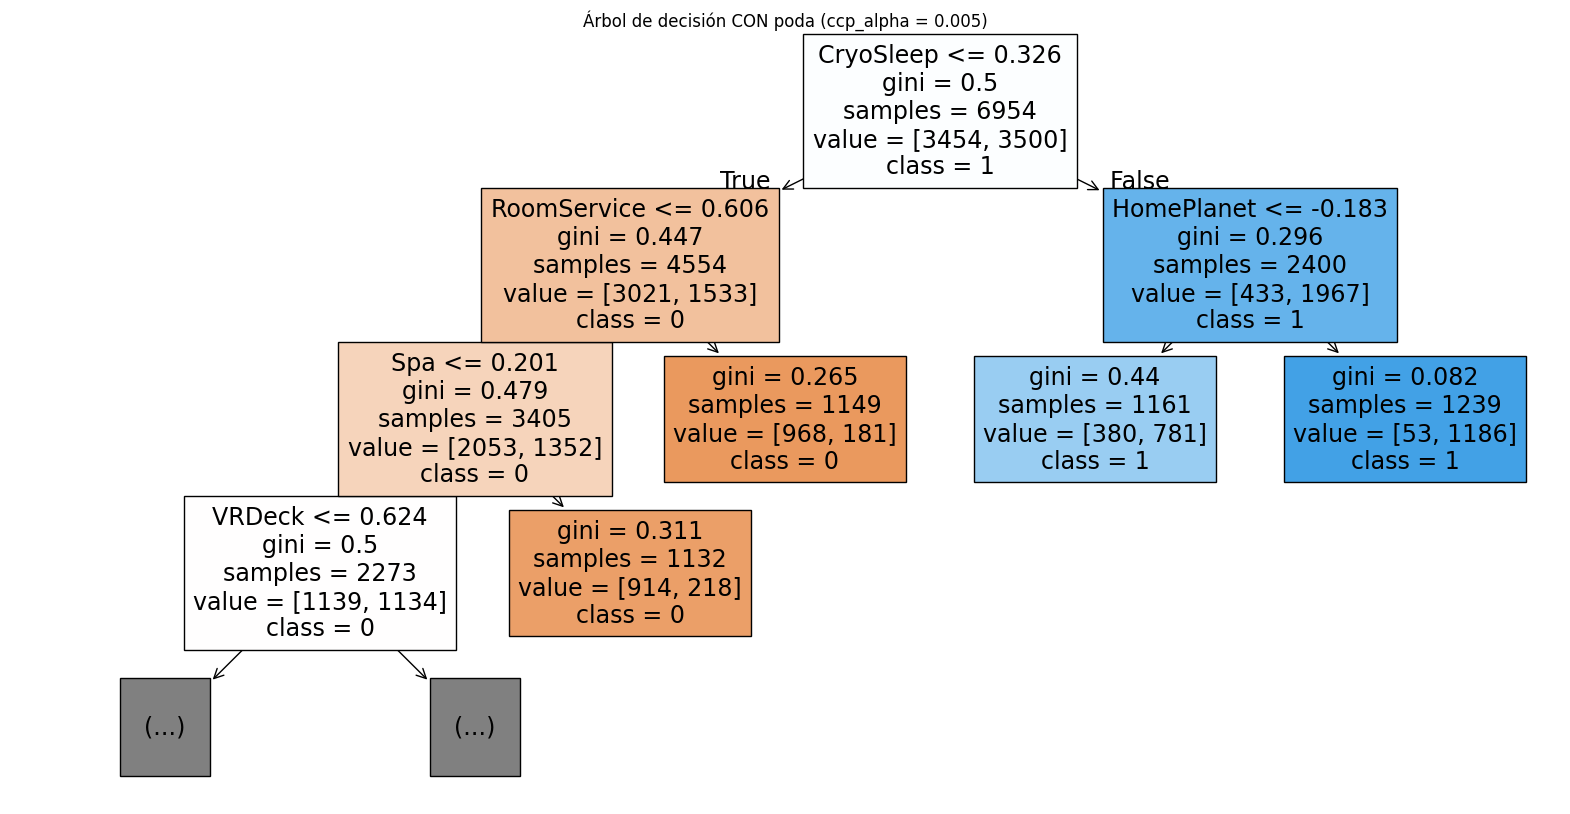

In [45]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ENTRENAR árbol SIN poda
tree_no_poda = DecisionTreeClassifier(random_state=42)
tree_no_poda.fit(X_train, y_train)

# ENTRENAR árbol CON poda
tree_poda = DecisionTreeClassifier(random_state=42, ccp_alpha=0.005)
tree_poda.fit(X_train, y_train)

# Predecir con el árbol con poda
y_pred_poda = tree_poda.predict(X_test)

# Calcular precisión
accuracy = accuracy_score(y_test, y_pred_poda)
print(f"Precisión del árbol con poda (ccp_alpha=0.005): {accuracy:.4f}")

# Matriz de confusión
cm_tree = confusion_matrix(y_test, y_pred_poda)
print("\nMatriz de confusión:")
print(cm_tree)

# Visualizar matriz
plt.figure(figsize=(6, 4))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de confusión - Árbol con poda")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()

# Informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred_poda))

# Obtener nombres de las columnas para mostrar en el gráfico
feature_names = X_imputed.columns

# Gráfico del árbol SIN poda
plt.figure(figsize=(20, 10))
plot_tree(
    tree_no_poda,
    filled=True,
    feature_names=feature_names,
    class_names=["0", "1"],
      # Limita visualmente el árbol a 3 niveles
)
plt.title("Árbol de decisión SIN poda (visualización hasta profundidad 3)")
plt.show()

# Gráfico del árbol CON poda
plt.figure(figsize=(20, 10))
plot_tree(
    tree_poda,
    filled=True,
    feature_names=feature_names,
    class_names=["0", "1"],
    max_depth=3
)
plt.title("Árbol de decisión CON poda (ccp_alpha = 0.005)")
plt.show()

Observando los resultados de los tres modelos anteriores, como mencione anteriormente los modelos de regresión Logística y LDA tuvieron una presición muy similar y comparando ambos modelos con el modelo de arbol de decisión al cual se le aplico un valor de poda de alpha = 0.005 para evitar el sobreajuste obtuvo una precisión de 77.29 por lo cual tiene un redimiento ligeramente menor a los modelos anteriores. A continuación realizare un modelo de random

Scores de validación cruzada (XGBoost): [0.79439252 0.80589504 0.80589504 0.79511143 0.80071942]
Precisión media: 0.8004026915060333
Desviación estándar: 0.004991025073282966

Precisión en el conjunto de prueba: 0.7964347326049454

Matriz de confusión:
[[661 200]
 [154 724]]


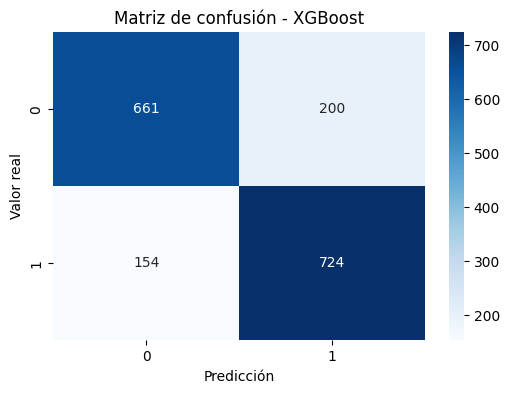


Informe de clasificación:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       861
           1       0.78      0.82      0.80       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739

Archivo 'submission_xgboost.csv' generado correctamente.


In [49]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Crear el modelo
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Validación cruzada
scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Scores de validación cruzada (XGBoost):", scores)
print("Precisión media:", np.mean(scores))
print("Desviación estándar:", np.std(scores))

# Entrenar el modelo completo
xgb_model.fit(X_train_scaled, y_train)

# Predecir en el conjunto de prueba
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Calcular precisión en test
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("\nPrecisión en el conjunto de prueba:", accuracy_xgb)

# Matriz de confusión
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("\nMatriz de confusión:")
print(cm_xgb)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de confusión - XGBoost")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()

# Informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred_xgb))


# ---------- PREDICCIÓN FINAL EN TEST.CSV CON XGBOOST ----------

# Asegurar que las columnas del test están en el mismo orden que en el entrenamiento
X_imputed_test = X_imputed_test[X_imputed.columns]

# Predecir con el modelo XGBoost entrenado
y_pred_final_xgb = xgb_model.predict(X_imputed_test)

# Convertir a booleano si es necesario
y_pred_final_xgb = y_pred_final_xgb.astype(bool)

# Añadir las predicciones al DataFrame original
data_test['Transported'] = y_pred_final_xgb

# Guardar archivo de predicciones final
data_test[['PassengerId', 'Transported']].to_csv('submission_xgboost.csv', index=False)
print("Archivo 'submission_xgboost.csv' generado correctamente.")

Al comparar los modelos evaluados anteriormente, se observa que tanto la regresión logística como el análisis discriminante lineal (LDA) obtuvieron una precisión aproximada del 78%, mientras que el modelo de árbol de decisión con poda alcanzó una precisión ligeramente inferior, en torno al 76%.

La implementación de el modelo de Boosting con XGBoost superó a los anteriores con un 79.29% de precisión. Posteriormente, al ajustar los hiperparámetros del modelo (como la profundidad, el número de árboles y la tasa de aprendizaje), se alcanzó una precisión de 79.96%, convirtiéndose en el modelo con mejor desempeño en este análisis hasta el momento.

Por ultimo realizare la prueba de un modelo

Precisión de Random Forest en test: 0.7826

Matriz de confusión:
[[683 178]
 [200 678]]


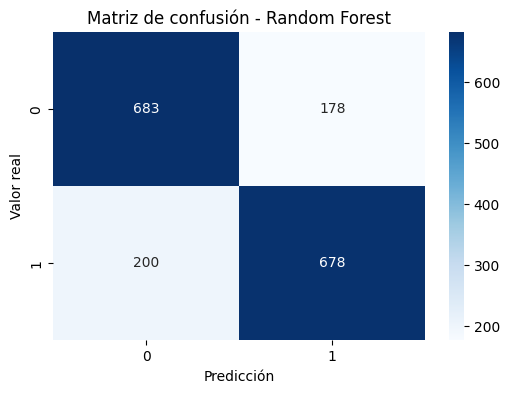


Informe de clasificación:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       861
           1       0.79      0.77      0.78       878

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739

Archivo 'submission_rf.csv' generado correctamente.


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicción
y_pred_rf = rf_model.predict(X_test)

# Precisión
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Precisión de Random Forest en test: {accuracy_rf:.4f}")

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\nMatriz de confusión:")
print(cm_rf)

# Visualización
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()

# Informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred_rf))


# PREDICCIÓN FINAL EN TEST :)

# Reemplazar X_train.columns por X_imputed.columns o data_train.drop('Transported', axis=1).columns
X_imputed_test = X_imputed_test[X_imputed.columns]

# Predecir con el modelo entrenado
y_pred_final_rf = rf_model.predict(X_imputed_test)

# Hacelo booleano
y_pred_final_rf = y_pred_final_rf.astype(bool)

# Añadir las predicciones al DataFrame original de test
data_test['Transported'] = y_pred_final_rf

# Guardar archivo con predicciones
data_test[['PassengerId', 'Transported']].to_csv('submission_rf.csv', index=False)
print("Archivo 'submission_rf.csv' generado correctamente.")

En resumen, obtuve los siguientes resultados para los modelos evaluados: XGBoost alcanzó la mayor precisión con un 79.64%, seguido de Random Forest con 78.26%, regresión logística multinomial con 78.28%, LDA con 76.76% y el árbol de decisión con poda con 76.60%. Estos resultados reflejan un rendimiento sólido y consistente entre los modelos, destacando XGBoost como la alternativa más precisa y eficaz para este problema de clasificación.

Este proyecto requirió tiempo y dedicación, pero fue especialmente valioso para consolidar los conocimientos adquiridos en clase, así como para comprender mejor el comportamiento de distintos modelos al compararlos entre sí. A pesar de los esfuerzos por mejorar la precisión, los incrementos obtenidos fueron mínimos, lo cual sugiere que se necesitarían técnicas más avanzadas —como optimización de hiperparámetros más profunda, selección de variables, o algunos otros métodos para lograr mejoras significativas en el rendimiento.

Este proyecto fue apoyado de lecturas previas de la clase, así como comentarios de kaggle, y ayuda de chatgpt